<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#!pip install finta
SID = '1472.tw'
df = web.DataReader(SID,'yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(4847, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2000-01-04,18.514601,17.7523,17.7523,18.187901,7346.0
2000-01-05,18.187901,17.7523,17.8612,18.187901,14709.0
2000-01-06,18.187901,17.9701,17.9701,18.187901,29382.0


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-04,32.299999,31.35,31.35,31.900000,349114.0
2019-09-05,31.900000,31.50,31.90,31.500000,22002.0
2019-09-06,33.200001,31.50,31.50,32.849998,1559169.0


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close, 1.07, 0.97, 20)['triple_barrier_signal']
df = df.join(ret)

In [6]:
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2019-08-08,33.400002,33.049999,33.049999,33.400002,27413.0,-1
2019-08-12,33.500000,33.099998,33.400002,33.500000,40000.0,0
2019-08-13,33.400002,33.099998,33.299999,33.400002,30000.0,0
2019-08-14,33.400002,32.799999,33.400002,33.250000,16703.0,0
2019-08-15,33.299999,33.000000,33.299999,33.200001,18000.0,0
2019-08-16,33.349998,33.000000,33.349998,33.250000,31054.0,0
2019-08-19,33.250000,32.900002,32.900002,33.200001,25895.0,0
2019-08-20,33.150002,32.200001,33.150002,33.150002,29677.0,0
2019-08-21,33.099998,31.850000,32.299999,32.700001,88533.0,0


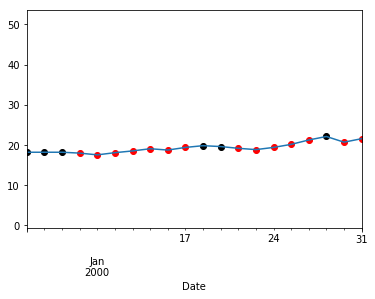

In [7]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][0:20].plot()
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    4844.000000
mean       48.185116
std        18.453953
min         0.000000
25%        35.883192
50%        47.399158
75%        59.642413
max        97.355196
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774


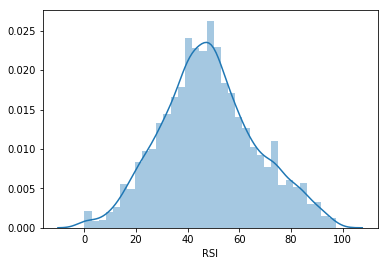

In [9]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    4795.000000
mean      -55.578010
std        29.490875
min      -100.000000
25%       -80.465251
50%       -59.374580
75%       -31.706752
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637


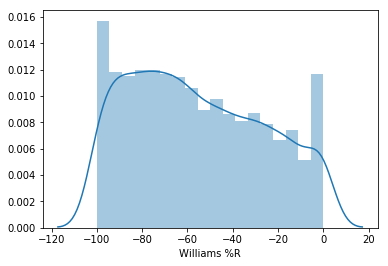

In [10]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count    4807.000000
mean       15.787358
std         9.513486
min         2.682878
25%         9.070213
50%        12.682983
75%        20.537444
max        44.206675
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073


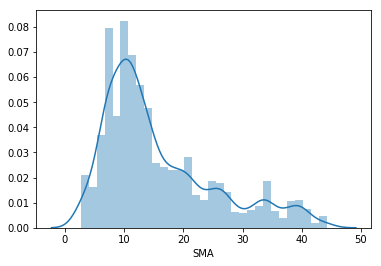

In [11]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count    4847.000000
mean       15.862510
std         9.626888
min         2.561923
25%         9.036171
50%        12.642330
75%        20.472422
max        47.856332
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316


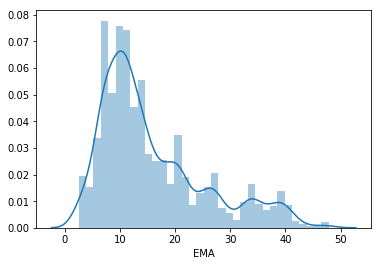

In [12]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count    4839.000000
mean       15.854952
std         9.651323
min         2.552904
25%         8.988392
50%        12.622600
75%        20.377467
max        49.100723
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778


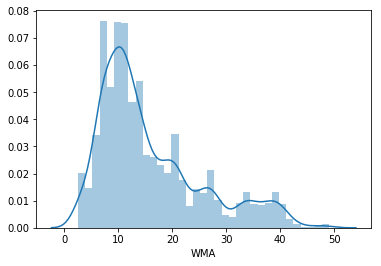

In [13]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count    4844.000000
mean       15.866682
std         9.669469
min         2.536421
25%         8.958491
50%        12.656880
75%        20.320595
max        49.568669
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000


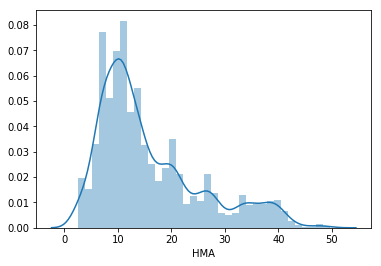

In [14]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count    4847.000000
mean       15.873784
std         9.690745
min         2.510762
25%         8.928692
50%        12.617293
75%        20.298771
max        50.758203
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176


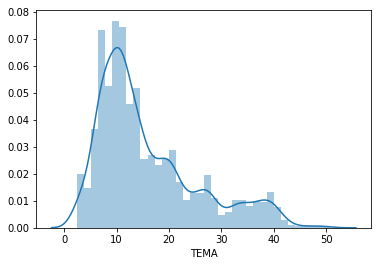

In [15]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    4846.000000
mean       -8.243907
std        90.030059
min      -283.235277
25%       -76.626148
50%       -18.907437
75%        57.323144
max       279.380434
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752


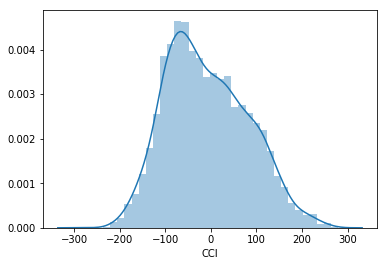

In [16]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    4794.000000
mean       -5.615308
std        46.006530
min      -100.000000
25%       -39.998161
50%        -6.122256
75%        25.872357
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976


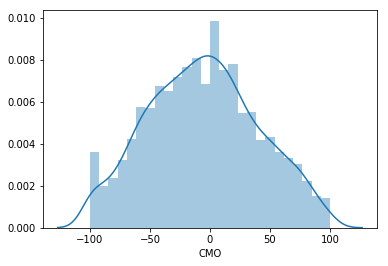

In [17]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    4847.000000
mean       -0.000311
std         0.208586
min        -1.171199
25%        -0.073383
50%         0.001228
75%         0.068020
max         1.937701
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479


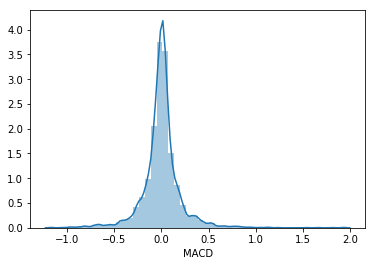

In [18]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    4847.000000
mean       -0.000983
std         1.105353
min        -4.522517
25%        -0.607218
50%        -0.023030
75%         0.540616
max         7.532199
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345,-0.326692
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719,-0.326501
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727,-0.241281
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545,-0.245294
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479,0.043070


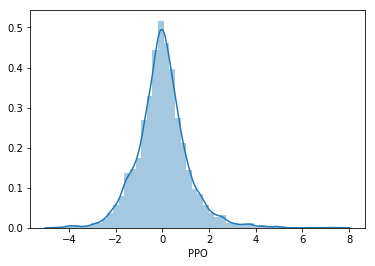

In [19]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    4835.000000
mean        0.807470
std        12.144048
min       -38.835056
25%        -5.633779
50%        -0.769231
75%         5.000052
max        84.987972
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345,-0.326692,-3.759398
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719,-0.326501,-4.819278
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727,-0.241281,-4.060152
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545,-0.245294,-5.120484
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479,0.043070,-0.904987


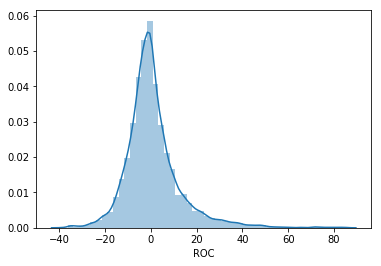

In [20]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    4.838000e+03
mean     3.112414e+08
std      1.243798e+08
min     -9.059855e+07
25%      2.065965e+08
50%      3.373200e+08
75%      4.154206e+08
max      4.881391e+08
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345,-0.326692,-3.759398,4.877076e+08
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719,-0.326501,-4.819278,4.877091e+08
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727,-0.241281,-4.060152,4.877293e+08
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545,-0.245294,-5.120484,4.877442e+08
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479,0.043070,-0.904987,4.881391e+08


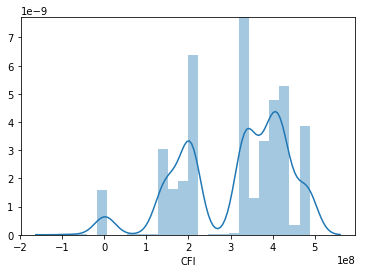

In [21]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    4764.000000
mean        4.168097
std        32.458958
min      -264.521331
25%       -11.666575
50%         0.641334
75%        14.474302
max       250.728624
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345,-0.326692,-3.759398,4.877076e+08,-11.260637
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719,-0.326501,-4.819278,4.877091e+08,-15.271919
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727,-0.241281,-4.060152,4.877293e+08,-2.146584
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545,-0.245294,-5.120484,4.877442e+08,-1.860372
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479,0.043070,-0.904987,4.881391e+08,21.947567


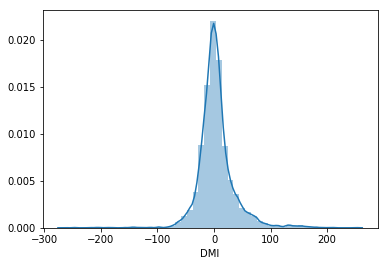

In [22]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count    4847.000000
mean       15.956618
std         9.748246
min         2.434160
25%         8.924571
50%        12.634600
75%        20.257200
max        52.399200
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,32.049999,31.90,31.900000,32.000000,54000.0,0,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345,-0.326692,-3.759398,4.877076e+08,-11.260637,33.526389
2019-09-03,31.700001,31.60,31.700001,31.600000,3500.0,0,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719,-0.326501,-4.819278,4.877091e+08,-15.271919,33.392806
2019-09-04,32.299999,31.35,31.350000,31.900000,349114.0,0,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727,-0.241281,-4.060152,4.877293e+08,-2.146584,33.267237
2019-09-05,31.900000,31.50,31.900000,31.500000,22002.0,0,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545,-0.245294,-5.120484,4.877442e+08,-1.860372,33.149203
2019-09-06,33.200001,31.50,31.500000,32.849998,1559169.0,0,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479,0.043070,-0.904987,4.881391e+08,21.947567,31.299999


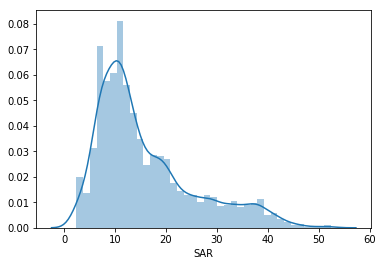

In [23]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [24]:
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #15個剛剛建立的技術指標
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(4720, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,38.863748,-74.074053,32.984147,32.161319,32.371112,31.775001,31.696991,-80.257734,-48.000031,-0.105345,-0.326692,-3.759398,4.877076e+08,-11.260637,33.526389,0
2019-09-03,31.372033,-88.888850,32.928049,32.049055,32.141112,31.685000,31.578322,-105.419949,-54.385998,-0.104719,-0.326501,-4.819278,4.877091e+08,-15.271919,33.392806,0
2019-09-04,41.183699,-77.777770,32.896342,32.019244,31.983334,31.890000,31.664011,-74.531404,-29.629685,-0.076727,-0.241281,-4.060152,4.877293e+08,-2.146584,33.267237,0
2019-09-05,33.758444,-92.592566,32.871952,31.915395,31.898889,31.810000,31.536907,-86.778797,-28.301911,-0.077545,-0.245294,-5.120484,4.877442e+08,-1.860372,33.149203,0
2019-09-06,61.082774,-42.592637,32.867073,32.102316,31.827778,31.795000,32.126176,3.100752,14.999976,0.015479,0.043070,-0.904987,4.881391e+08,21.947567,31.299999,0


# 相關性分析

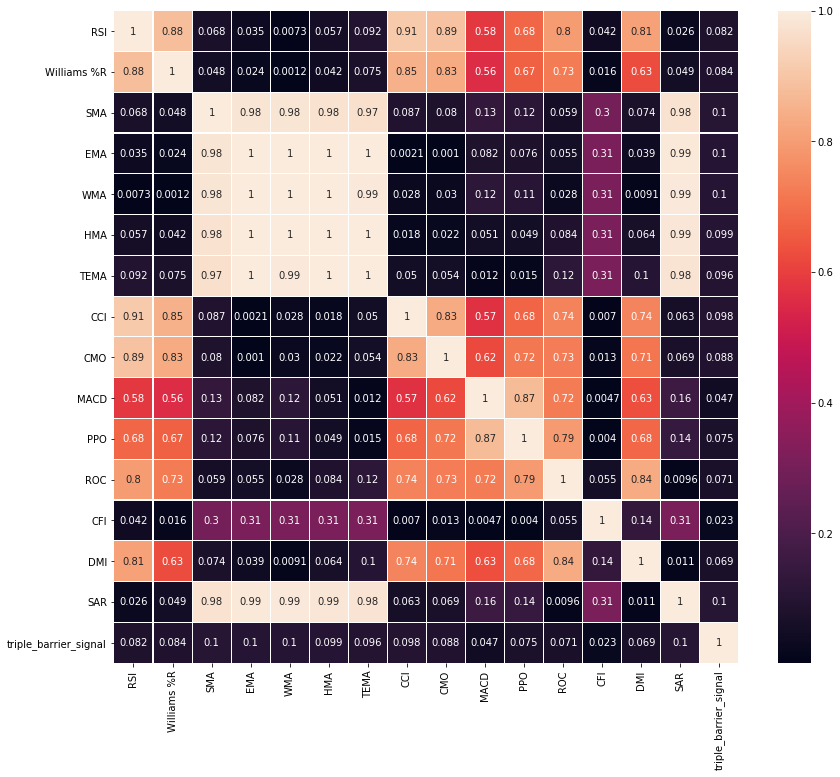

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index=df.index,
                         columns=df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
print(df_minmax.describe())
df_minmax.tail()

               RSI  Williams %R  ...          SAR  triple_barrier_signal
count  4720.000000  4720.000000  ...  4720.000000            4720.000000
mean      0.491499     0.441601  ...     0.268306              -0.274153
std       0.188702     0.294352  ...     0.197071               0.915044
min       0.000000     0.000000  ...     0.000000              -1.000000
25%       0.366782     0.192533  ...     0.127564              -1.000000
50%       0.484029     0.402729  ...     0.198864              -1.000000
75%       0.605407     0.679992  ...     0.354299               1.000000
max       1.000000     1.000000  ...     1.000000               1.000000

[8 rows x 16 columns]


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,0.399168,0.259259,0.729733,0.653489,0.640593,0.621671,0.604928,0.360775,0.260000,0.342840,0.348065,0.283272,0.999254,0.491530,0.622280,0
2019-09-03,0.322212,0.111112,0.728382,0.651010,0.635652,0.619757,0.602468,0.316051,0.228070,0.343041,0.348081,0.274713,0.999257,0.483745,0.619606,0
2019-09-04,0.422998,0.222222,0.727618,0.650352,0.632262,0.624116,0.604244,0.370953,0.351852,0.352045,0.355150,0.280844,0.999292,0.509218,0.617093,0
2019-09-05,0.346725,0.074074,0.727031,0.648060,0.630448,0.622415,0.601610,0.349184,0.358490,0.351782,0.354817,0.272280,0.999318,0.509774,0.614731,0
2019-09-06,0.627405,0.574074,0.726913,0.652186,0.628920,0.622096,0.613824,0.508937,0.575000,0.381703,0.378739,0.306325,1.000000,0.555980,0.577721,0


In [27]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [28]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

for i in tqdm(range(b_index,f_index,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 4705/4705 [00:09<00:00, 478.54it/s]


準備完成


# check

In [29]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 4705
第一筆的index開始和結束:2000-04-28-2000-05-19
最後一筆的index開始和結束:2019-08-15-2019-09-06


# Reshape X

(圖片數量,長,寬,1張)

In [30]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(4705, 15, 15)
(4705, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [31]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(4705, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]]


Using TensorFlow backend.


(4705, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

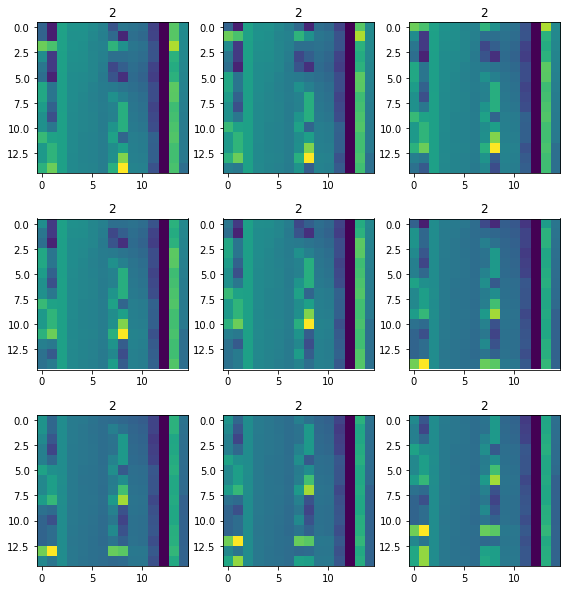

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [33]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(4665, 15, 15, 1) (4665, 3) (40, 15, 15, 1)


In [34]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2,
                                              random_state=42,
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(3732, 15, 15, 1) (3732, 3) (933, 15, 15, 1) (933, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [35]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

2    2792
1    1506
0     407
dtype: int64

In [36]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

2    2245
1    1191
0     296
dtype: int64

In [37]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

2    536
1    315
0     82
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [39]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(nclasses, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    


In [40]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_loss',#驗證集loss
                   min_delta=0, 
                   patience=20,  
                   mode='min',
                   restore_best_weights=False)#恢復最佳權重

# fit

In [42]:
history = model.fit(xtrain,ytrain,
                    batch_size=128,
                    epochs=200,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3732 samples, validate on 933 samples
Epoch 1/200
3732/3732 [==============================] - 3s 823us/step - loss: 0.9023 - acc: 0.5809 - val_loss: 0.8932 - val_acc: 0.5745
Epoch 2/200
3732/3732 [==============================] - 0s 56us/step - loss: 0.8690 - acc: 0.6010 - val_loss: 0.8901 - val_acc: 0.5745
Epoch 3/200
3732/3732 [==============================] - 0s 50us/step - loss: 0.8651 - acc: 0.5991 - val_loss: 0.8853 - val_acc: 0.5831
Epoch 4/200
3732/3732 [==============================] - 0s 50us/step - loss: 0.8631 - acc: 0.6016 - val_loss: 0.8978 - val_acc: 0.5745
Epoch 5/200
3732/3732 [==============================] - 0s 47us/step - loss: 0.8565 - acc: 0.5991 - val_loss: 0.9031 - val_acc: 0.5745
Epoch 6/200
3732/3732 [==============================] - 0s 47us/step - loss: 0.8513 - acc: 0.6018 - val_loss: 0.8822 - val_acc: 0.5756
Epoch 7/200
3732/3732 [===================

# 訓練過程評估

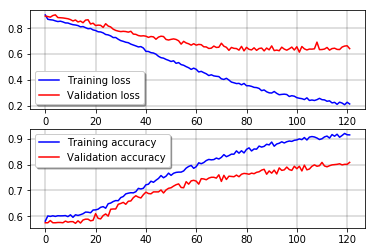

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

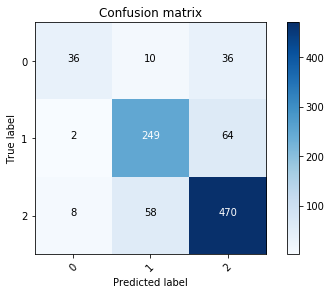

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [45]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


真實y值

In [46]:
print(yval[:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


# 分類報告

In [47]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.78      0.44      0.56        82
         BUY       0.79      0.79      0.79       315
        SELL       0.82      0.88      0.85       536

   micro avg       0.81      0.81      0.81       933
   macro avg       0.80      0.70      0.73       933
weighted avg       0.81      0.81      0.80       933
 samples avg       0.81      0.81      0.81       933



# plot error

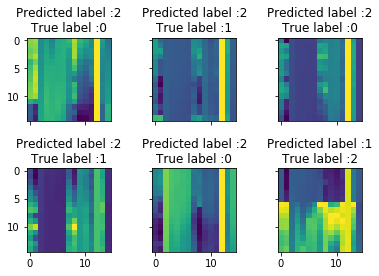

In [48]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

## 預測最後40筆

In [49]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 0~20筆

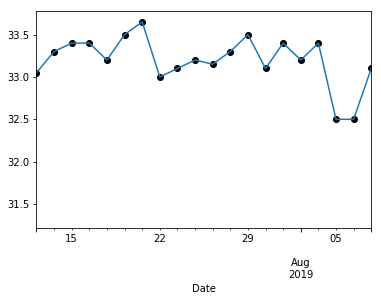

In [50]:
INDEX60 = df[-60:].index
C = web.DataReader(SID,'yahoo',start="2000-01-01")[['Close']]
C = C.loc[INDEX60,:]
C['SIGNAL'] = [np.nan for _ in range(20)] + answer #20個NAN+預測答案
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'][20:40].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')

# 20~40筆

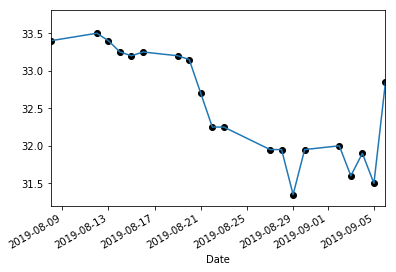

In [51]:
C['Close'][40:60].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')

# 合併

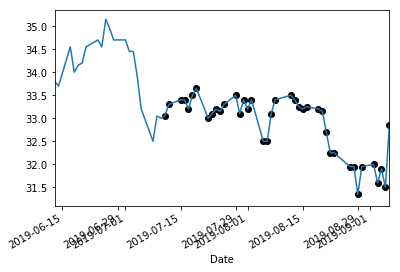

In [52]:
C['Close'][0:60].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')

# 平滑版本

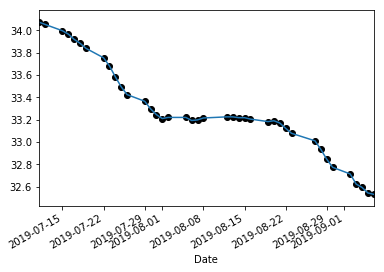

In [53]:
C_roll20 = pd.DataFrame(index=C.index)#空的dataframe index = 倒數60天股票日期
C_roll20['Close'] = C['Close'].rolling(20).mean()#收盤價做20天平滑
C_roll20['SIGNAL'] = C['SIGNAL']
buy = C_roll20[C_roll20['SIGNAL']==1]['Close']#買點
sell= C_roll20[C_roll20['SIGNAL']==2]['Close']#賣點
C_roll20['Close'][20:].plot()
plt.scatter(buy.index,buy.values,color='red',marker="^")
plt.scatter(sell.index,sell.values,color='black')